In [1]:
import sys
import os

current_dir = os.getcwd() 
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
os.environ["OMP_NUM_THREADS"] = '2'

import warnings
warnings.filterwarnings("ignore")

In [2]:
from Tbx_Clustering import *
from Tsbx_Exploratory import *
from Tbx_Exploratory import *

from Tbx_Processing import create_labels

# Tópicos de séries temporais

In [3]:
# Dados com endereço & PDE
pdes = pd.read_csv('../results/pdes_consumo.csv', dtype = str)
pdes = pdes[['PDE', 'TIPO_RUA', 'DESC_RUA', 'NUMERO_RUA', 'CEP', 'COORD_Y', 'LAT', 'LONG']]

pdes['PDE'] = pdes['PDE'].apply(
    lambda x: x.zfill(10)
    )

# Dados de consumo com PDE
data_raw = pd.read_excel('../data/Consumo_PDE.xlsx', dtype = str)

data_pde = clean_pde_data(data_raw = data_raw)
data_pde.head()

,PDE,QTD_CONSUMO,QTD_CONSUMO_MEDIO,YEAR,DATE
timestamp,,,,,
2021-11-26 23:59:59,0162962908,20,18,2021,2021-11
2021-12-27 23:59:59,0162962908,38,19,2021,2021-12
2022-01-26 23:59:59,0162962908,21,22,2022,2022-1
2022-02-23 23:59:59,0162962908,24,22,2022,2022-2
2022-03-26 23:59:59,0162962908,11,24,2022,2022-3


## Suavização das séries e análise sazonalidade

***///***///***///***///***///***///***///***///***///***///***///***///***///***///***///
HERBERT FRAZER_963
Quantidade de consumidores: 399
Quantidade de observações: 13101
['0185833772']
Casos ATENÇÃO!!	301


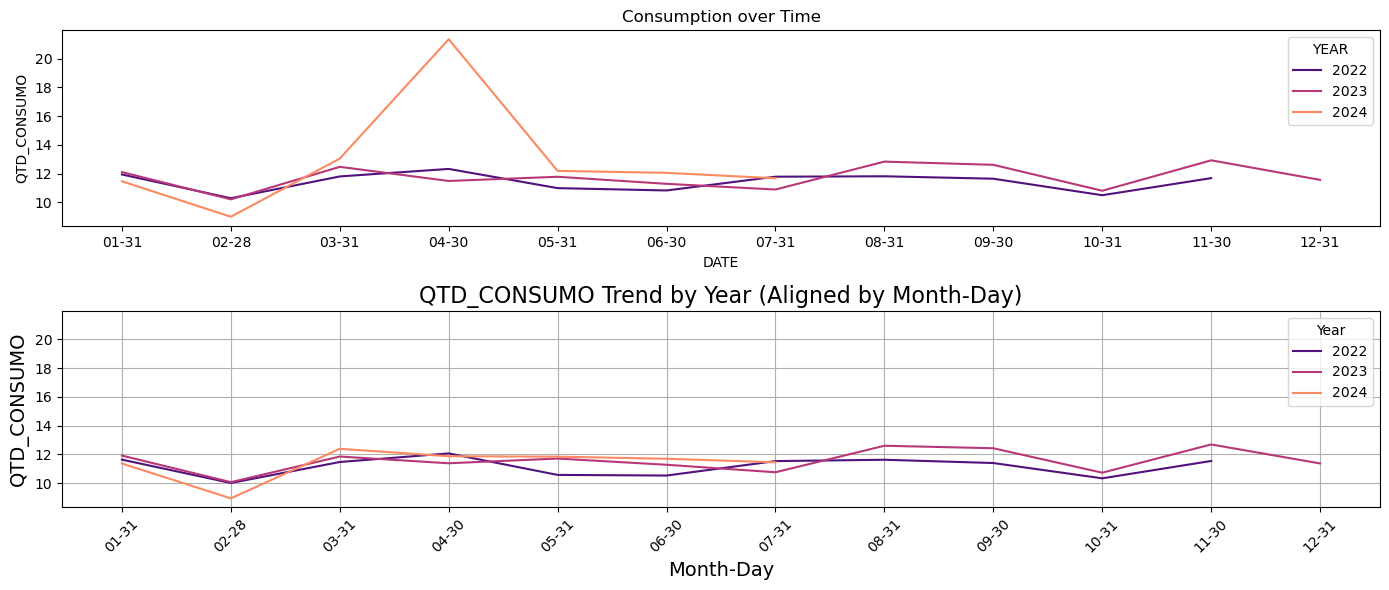

Tamanho cluster 2:	74 / 398
Tamanho cluster 1:	324 / 398


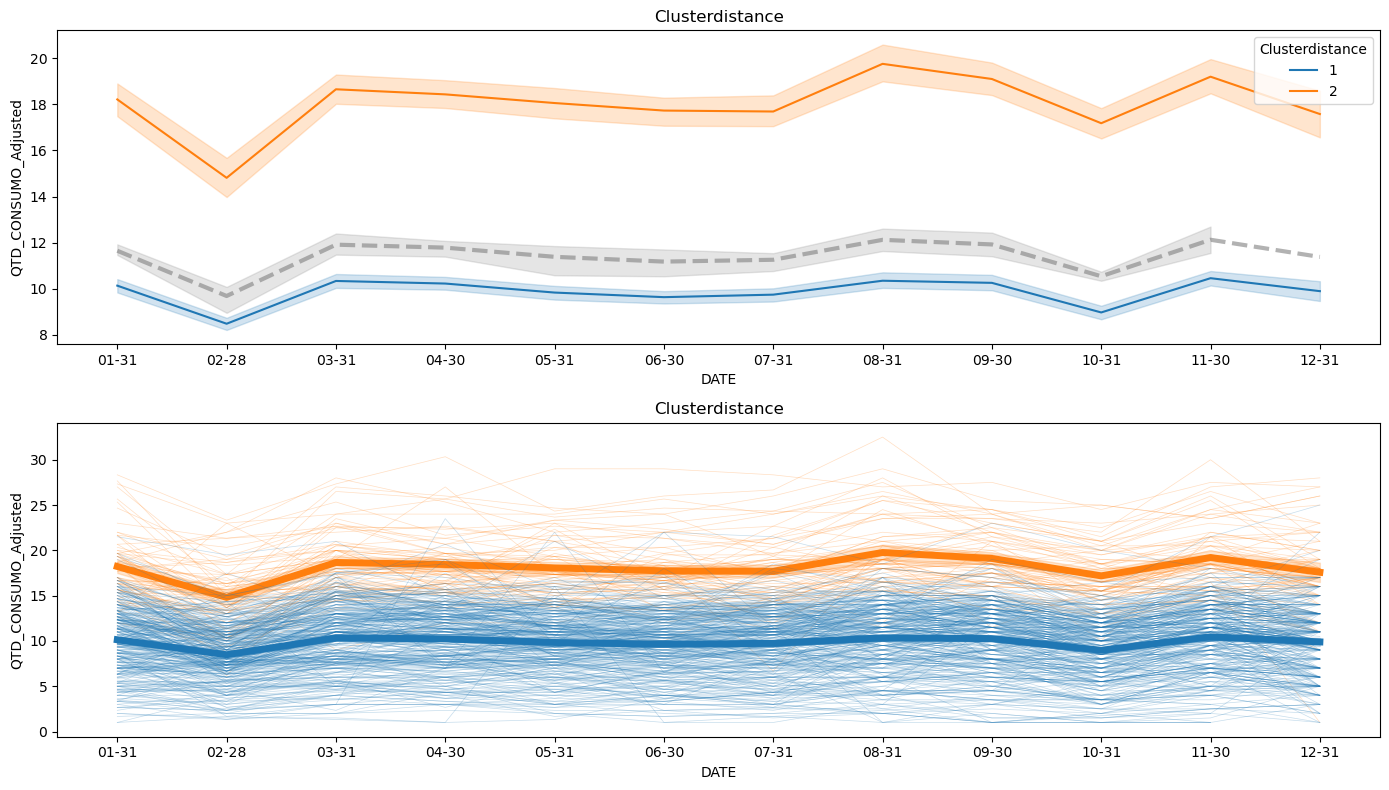

***///***///***///***///***///***///***///***///***///***///***///***///***///***///***///
ANGA_896
Quantidade de consumidores: 389
Quantidade de observações: 12046
['0798030160']
Casos ATENÇÃO!!	551


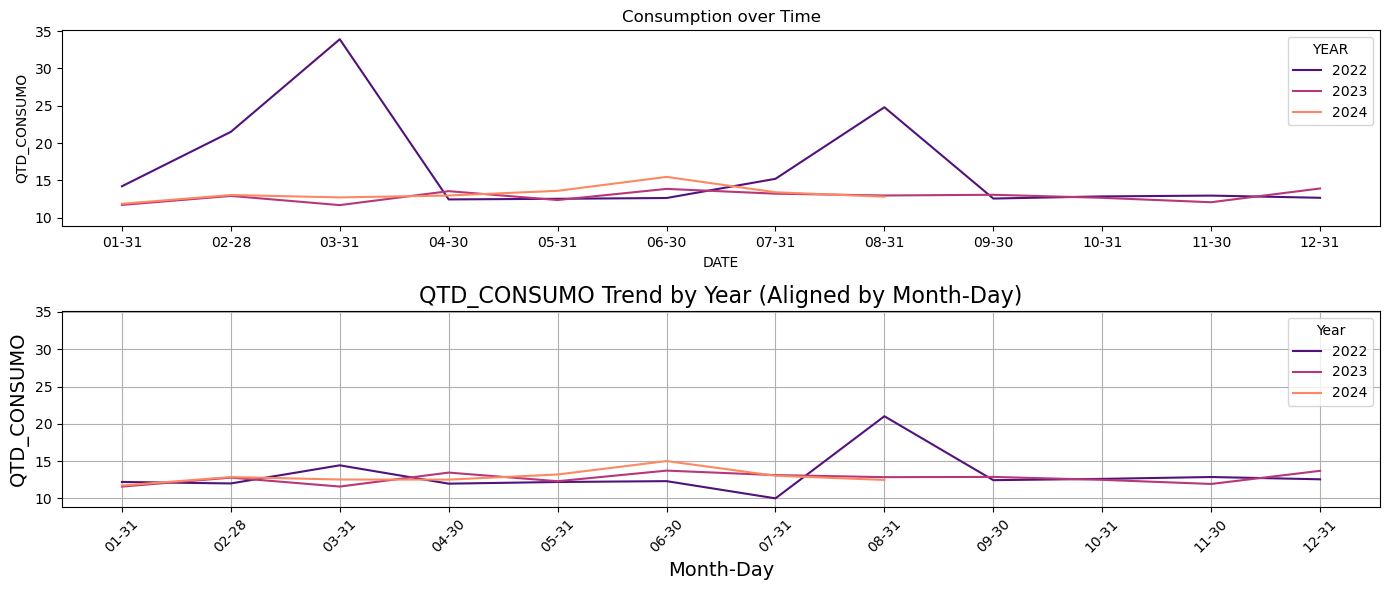

Tamanho cluster 1:	135 / 388
Tamanho cluster 2:	253 / 388


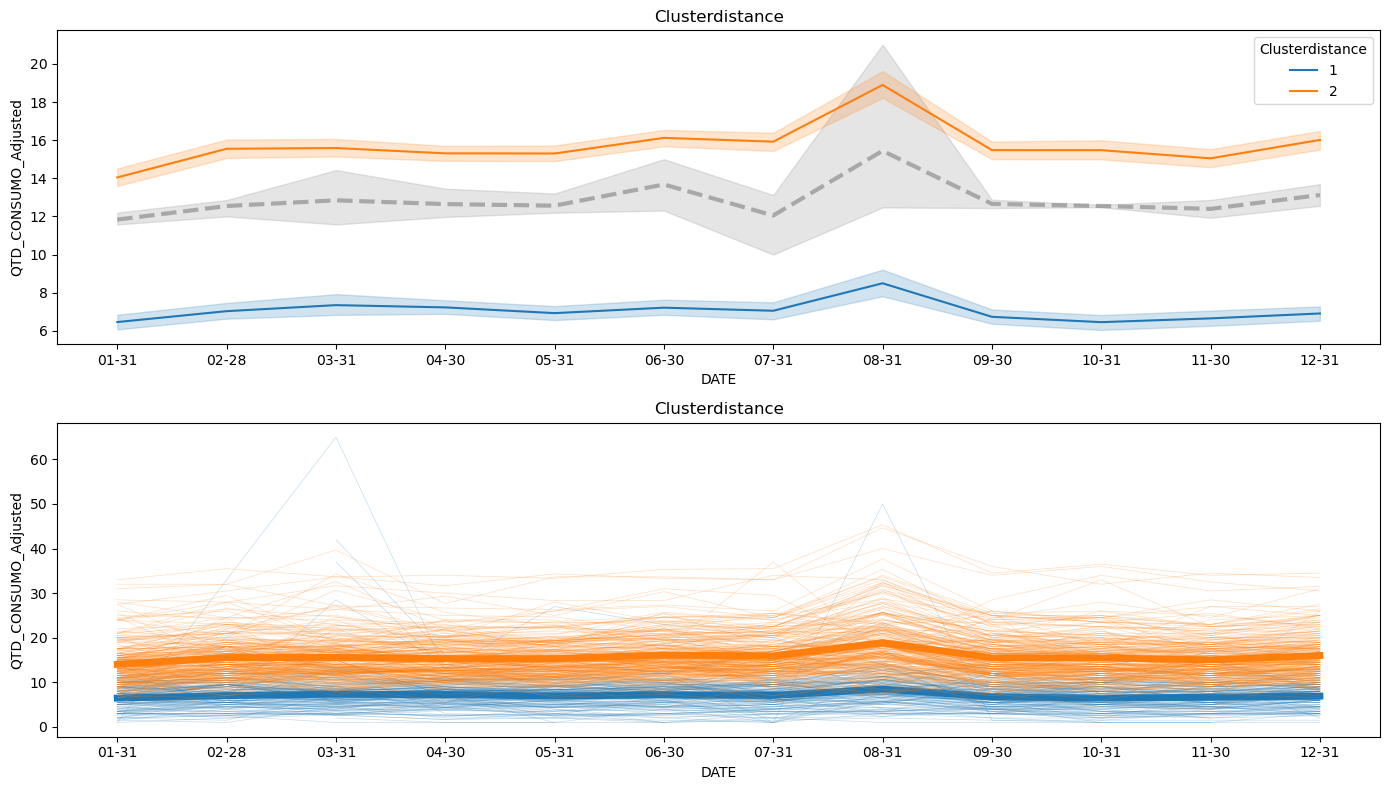

***///***///***///***///***///***///***///***///***///***///***///***///***///***///***///
ENEAS DE BARROS_769
Quantidade de consumidores: 19
Quantidade de observações: 643
[]
Casos ATENÇÃO!!	9


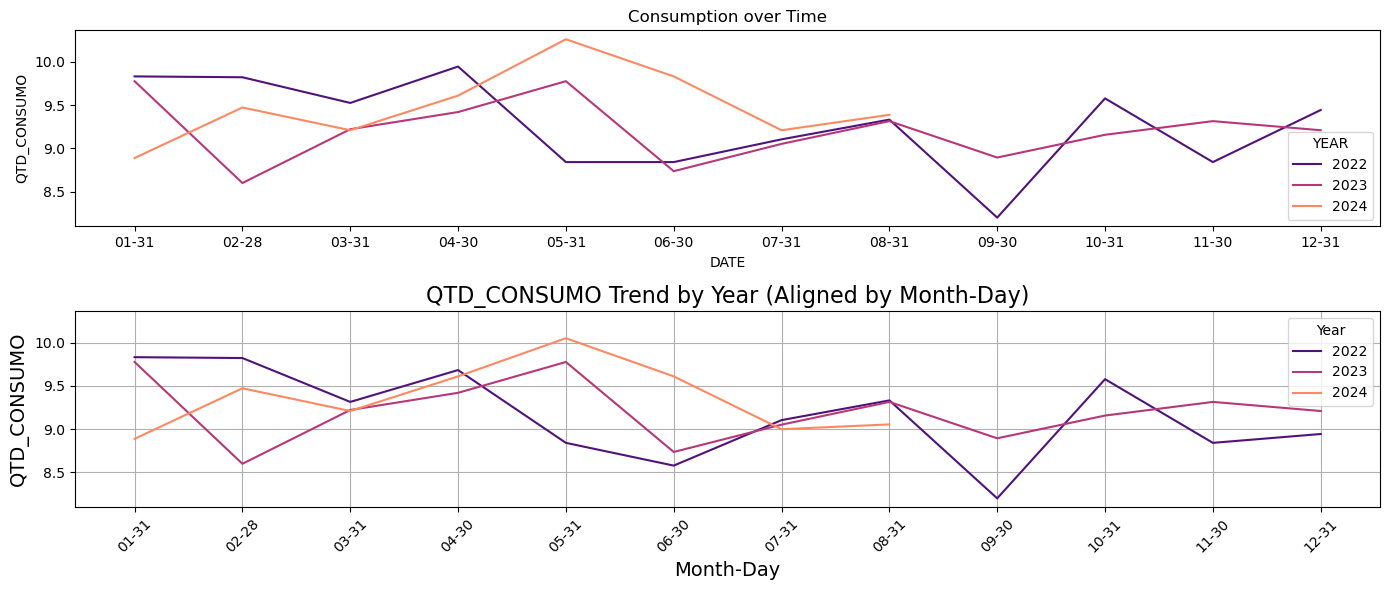

Tamanho cluster 1:	8 / 19
Tamanho cluster 2:	11 / 19


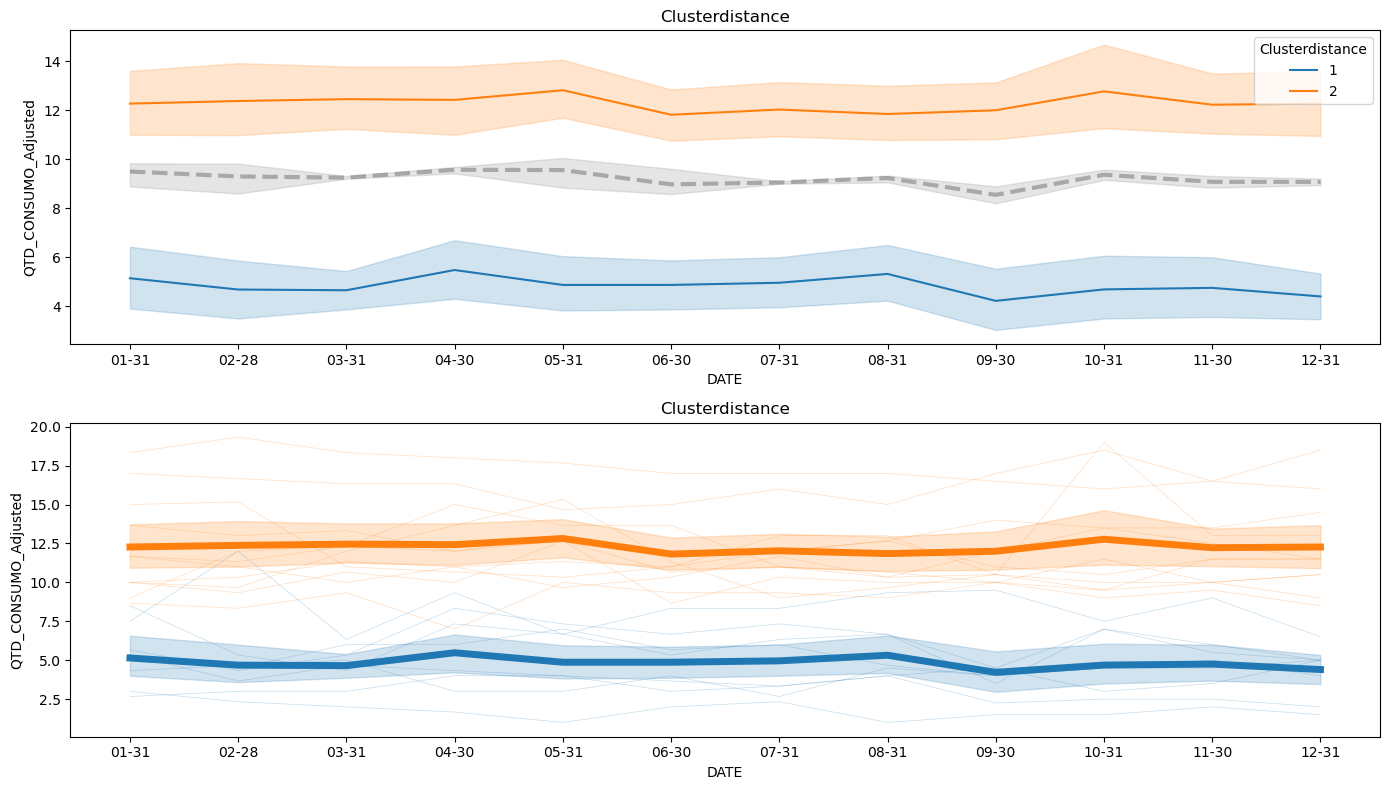

In [4]:
threshold = 3
limit_status = 2.25
prototype_list = []

id_local = pdes[['DESC_RUA', 'NUMERO_RUA']].drop_duplicates()
id_local = id_local.iloc[[1, 3, 5], :]

for desc_rua, numero_rua in zip(id_local['DESC_RUA'], id_local['NUMERO_RUA']):
    tag = desc_rua + '_' + numero_rua.replace('.0', '')

    print(15 * '***///')
    print(tag)
    pdes_tgt = pdes[(pdes['DESC_RUA'] == desc_rua) & (pdes['NUMERO_RUA'] == numero_rua)]

    data_tgt = exploratory_processing(data = data_pde,
                                      pde_list = pdes_tgt['PDE'],
                                      remove_zero_consumption = True,
                                      factor_remove = 5, return_removed = False)

    data_tgt = smooth_consumption(data = data_tgt,
                                  tgt_feat = 'QTD_CONSUMO',
                                  ref_feat = 'Consumo_Mediano',
                                  threshold = threshold,
                                  limit_status = limit_status)

    plot_hued_by_year(data = data_tgt,
                      variable = 'QTD_CONSUMO',
                      start_date = '2022-01-01',
                      end_date = '2025-01-01',
                      granularity = 'M',
                      adjust_consumption = True,
                      exclude_case = None)

    data_cluster, data_resampled = cluster_consumers(data = data_tgt.drop(columns = 'Status'),
                                                     y_feat = 'QTD_CONSUMO_Adjusted', id_feat = 'PDE',
                                                     num_clusters = 2,
                                                     method = 'distance', metric = 'cityblock')

    # data_resampled['ID'] = tag + '__All___' + str(pdes_tgt.shape[0])
    # consumption_full = data_resampled.pivot(index = ['ID'], columns = 'timestamp',
    #                                         values = 'QTD_CONSUMO_Adjusted').reset_index()
    # prototype_list.append(consumption_full)
    #
    # data_cluster_agg = data_cluster[['timestamp', 'Cluster', 'Cl1_count', 'Cl2_count', 'QTD_CONSUMO_Adjusted']].groupby(
    #     ['timestamp', 'Cluster', 'Cl1_count', 'Cl2_count']).mean().reset_index()
    # data_cluster_agg['ID'] = tag + '__C' + data_cluster_agg['Cluster'].astype(str) + '___' + data_cluster_agg[
    #     'Cl1_count'].astype(str) + '_' + data_cluster_agg['Cl2_count'].astype(str)
    #
    # consumption_pde = data_cluster_agg.pivot(index = ['ID'], columns = 'timestamp',
    #                                          values = 'QTD_CONSUMO_Adjusted').reset_index()
    # prototype_list.append(consumption_pde)

# Quanto ao padrao

In [5]:
# @Carregar arquivo salvo
# Correspondencias SABESP - GeoEmbraesp
df_iptu_geo = pd.read_pickle("../2_PreProcessamento/data_clean/df_pde_iptu.pkl")
df_iptu_geo.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,CEP,Idade_predio,Blocos,Unidades_andar,Andares_tipo,Total_Unidades,Elevadores,...,FATOR DE OBSOLESCENCIA,CONTAGEM_UNIDADES,VALOR DO M2 DO TERRENO,AREA DO TERRENO,VALOR DO M2 DE CONSTRUCAO,AREA CONSTRUIDA,Padrao,Fator_obsolescencia_calculado,PDE,PDE_Count
0,GOLDEN PALACE,ABAGIBA,540.0,04294-000,29,1.0,4.0,8.0,32.0,2.0,...,0.74,32.0,1557.0,1000.0,2291.0,3424.0,C,0.71,0409469165,1.0
1,RESERVA SAÚDE,ABAGIBA,582.0,04294-000,8,1.0,6.0,17.0,102.0,2.0,...,0.96,102.0,1557.0,2935.0,2291.0,10603.0,C,0.94,0072401044,1.0
2,MISSOURI,ABAGIBA,583.0,04294-000,29,1.0,4.0,19.0,76.0,2.0,...,0.74,76.0,1602.0,1500.0,2291.0,10703.0,C,0.71,0072428759,1.0
3,VILA PIEMONTE,ABAGIBA,603.0,04294-000,27,1.0,4.0,14.0,56.0,2.0,...,0.80,56.0,1602.0,1000.0,2291.0,6778.0,C,0.74,0072428678,1.0
4,VALE DO SOL,ABAGIBA,1200.0,04294-000,17,2.0,4.0,10.5,84.0,6.0,...,0.88,116.0,1606.0,2312.0,2291.0,14636.0,C,0.85,0705845320,1.0


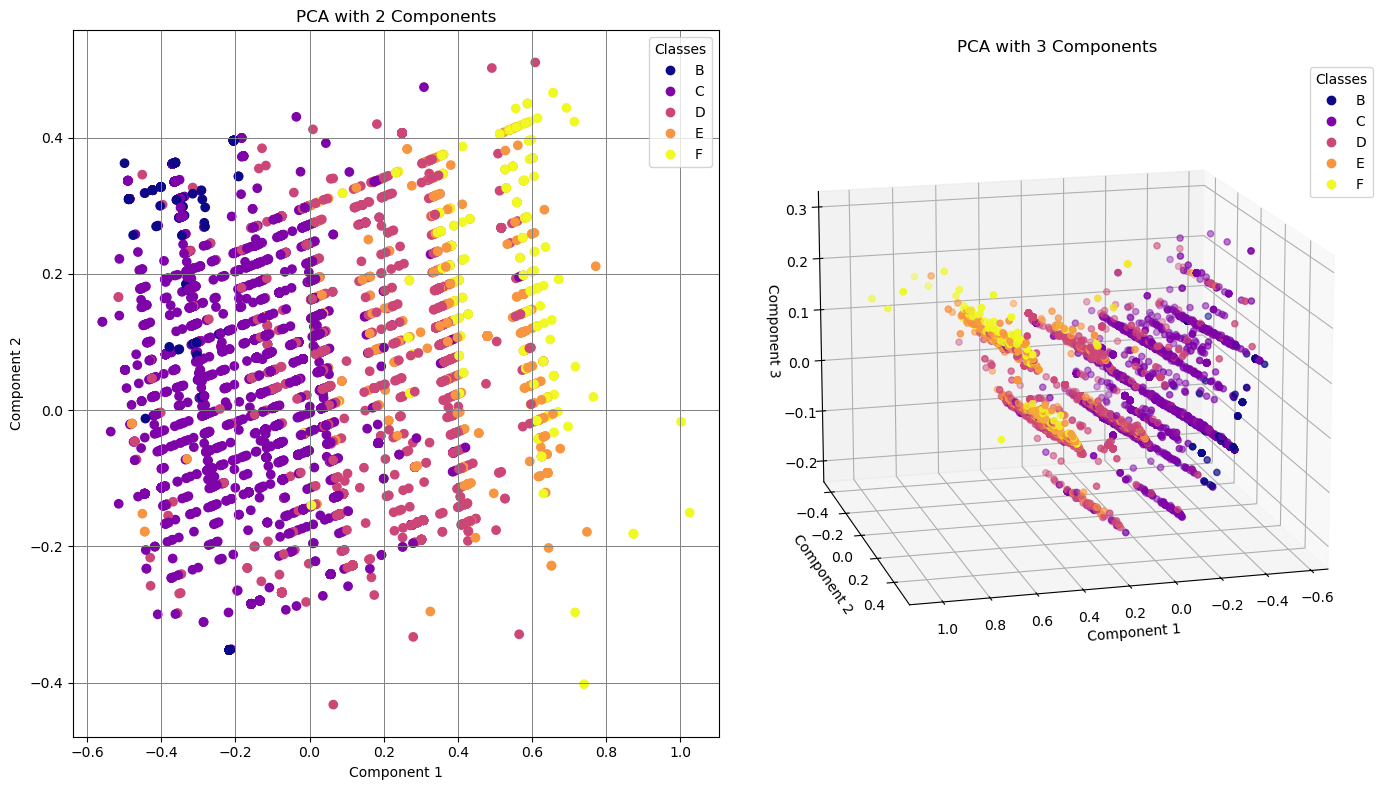

In [6]:
initial_report(data=df_iptu_geo[['Andares_tipo', 'Dormitorios', 'Banheiros_Sociais', 'M2_total_unidade_tipo', 'Padrao']], target='Padrao', method = 'PCA',
               filename = None, scale=True, elev=15, azim=75)

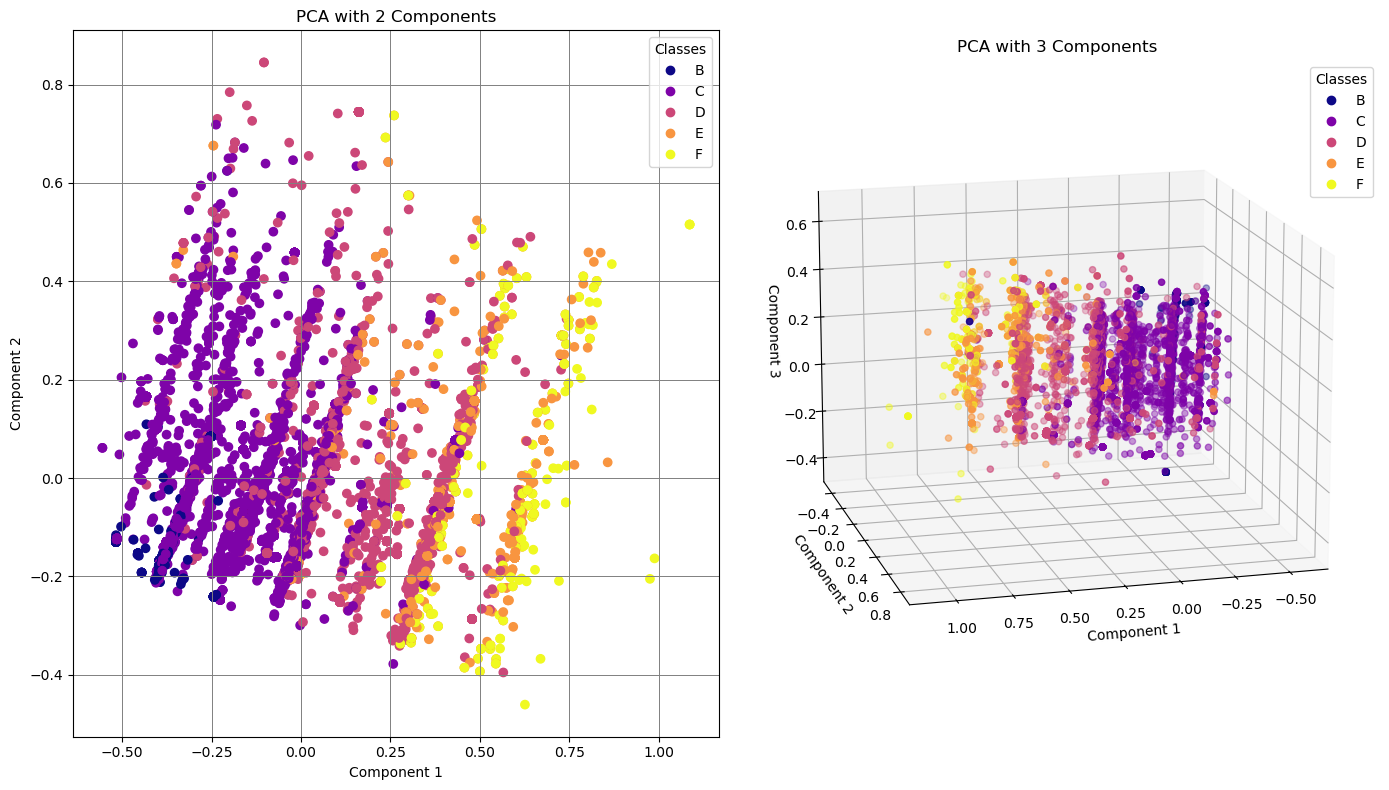

In [7]:
initial_report(data=df_iptu_geo[['Andares_tipo', 'Dormitorios', 'Banheiros_Sociais', 'M2_total_unidade_tipo', 'VALOR DO M2 DO TERRENO', 'Padrao']], target='Padrao', method = 'PCA',
               filename = None, scale=True, elev=15, azim=75)

In [8]:
# initial_report(data = df_iptu_geo[
#     ['Idade_predio', 'Andares_tipo', 'Total_Unidades', 'Banheiros_Sociais', 'M2_total_unidade_tipo', 'M2_total_cobertura', 'Padrao']],
#                target = 'Padrao', method = 'tSNE', filename = None, scale = True, elev = 15, azim = 45)

In [9]:
pdes_dict = pd.read_csv('../results/Lista_PDE_0410.csv', dtype = str)

pdes_dict['PDE'] = pdes_dict['PDE'].apply(
    lambda x: x.zfill(10)
    )

pdes_dict

,DESC_RUA,NUMERO_RUA,PDE
0,FIRMINO BRAGA,55.0,1062779522
1,FIRMINO BRAGA,55.0,1062780105
2,FIRMINO BRAGA,55.0,1062781420
3,FIRMINO BRAGA,55.0,1062774300
4,FIRMINO BRAGA,55.0,1062771629
...,...,...,...
7668,SAID AIACH,277.0,0877076324
7669,SAID AIACH,277.0,0877078297
7670,BENTA PEREIRA,390.0,0099333520
7671,AGNALDO MANUEL DOS SANTOS,270.0,0078949700


In [10]:
# Dados de consumo com PDE
data_raw_V2 = pd.read_csv('../data/Consumo_PDE_V2.csv', dtype = str)

data_pde_V2 = clean_pde_data(data_raw = data_raw_V2)
data_pde_V2.head()

,PDE,QTD_CONSUMO,QTD_CONSUMO_MEDIO,YEAR,DATE
timestamp,,,,,
2021-11-12 23:59:59,0052804860,19,17,2021,2021-11
2021-12-13 23:59:59,0052804860,19,18,2021,2021-12
2022-01-12 23:59:59,0052804860,14,18,2022,2022-1
2022-02-11 23:59:59,0052804860,20,18,2022,2022-2
2022-03-14 23:59:59,0052804860,18,18,2022,2022-3


In [11]:
MIN_UNID = 50


df_IGS = df_iptu_geo[df_iptu_geo['PDE'].isin(pdes_dict['PDE'])].copy()

df_IGS = df_IGS[df_IGS['PDE_Count'] == 1]
df_IGS.drop(columns = 'PDE_Count', inplace = True)

df_IGS = df_IGS[(df_IGS['Total_Unidades'] >= MIN_UNID) | (df_IGS['CONTAGEM_UNIDADES'] >= MIN_UNID)]
df_IGS['ratio_units'] = df_IGS['Total_Unidades'] / df_IGS['CONTAGEM_UNIDADES']

def bin_feature(data, tgt_val, tag, bins):
    labels = create_labels(bins)
    data[tag + '_bins'] = pd.cut(data[tgt_val], bins = bins, labels = labels)

df_IGS['Dormitorios'] = df_IGS['Dormitorios'].replace(0, 1)

bin_feature(data = df_IGS, tgt_val = 'Dormitorios', tag = 'dormitorios', bins = [0, 1, 2, 3, np.inf])
bin_feature(data = df_IGS, tgt_val = 'Banheiros_Sociais', tag = 'banheiros', bins = [0, 1, 2, 3, np.inf])
bin_feature(data = df_IGS, tgt_val = 'AREA DO TERRENO', tag = 'Area_terr', bins = [500, 1500, 2500, 4000, np.inf])
bin_feature(data = df_IGS, tgt_val = 'M2_total_unidade_tipo', tag = 'm2_tipo', bins = [0, 50, 100, 200, 300, np.inf])
bin_feature(data = df_IGS, tgt_val = 'Idade_predio', tag = 'idade', bins = [0, 10, 17, np.inf])

df_IGS_clean = df_IGS[['Empreendimento_Nome', 'DESC_RUA', 'NUMERO_RUA', 'Padrao', 'M2_total_unidade_tipo',
                       	'dormitorios_bins', 'banheiros_bins', 'Area_terr_bins',	'm2_tipo_bins',	'idade_bins',
                       'Total_Unidades', 'CONTAGEM_UNIDADES', 'ratio_units',  'PDE']]

df_IGS_clean

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,Padrao,M2_total_unidade_tipo,dormitorios_bins,banheiros_bins,Area_terr_bins,m2_tipo_bins,idade_bins,Total_Unidades,CONTAGEM_UNIDADES,ratio_units,PDE
1,RESERVA SAÚDE,ABAGIBA,582.0,C,124.710000,1-2,1-2,2500-4000,100-200,0-10,102.0,102.0,1.000000,0072401044
4,VALE DO SOL,ABAGIBA,1200.0,C,143.000000,2-3,1-2,1500-2500,100-200,10-17,84.0,116.0,0.724138,0705845320
5,PLANO & ERMELINO ABEL TAVARES II,ABEL TAVARES,1441.0,B,55.390000,1-2,0-1,1500-2500,50-100,0-10,165.0,165.0,1.000000,0581277988
6,PLANO & ERMELINO ABEL TAVARES I,ABEL TAVARES,1607.0,B,58.800000,1-2,0-1,2500-4000,50-100,0-10,165.0,165.0,1.000000,0932466257
7,PERSONA PARAÍSO,ABILIO SOARES,509.0,C,130.000000,1-2,1-2,500-1500,100-200,10-17,60.0,93.0,0.645161,0079552510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12771,VILA IMPERIAL,XAVIER DE ALMEIDA,918.0,D,241.746667,3+,2-3,4000+,200-300,17+,264.0,311.0,0.848875,0073904325
12783,PROJETO VIVER JARDIM MARAJOARA,YERVANT KISSAJIKIAN,299.0,C,86.780000,1-2,0-1,4000+,50-100,17+,314.0,314.0,1.000000,0060986654
12784,RESIDENCIAL LIBERTY,YERVANT KISSAJIKIAN,539.0,C,110.000000,1-2,0-1,1500-2500,100-200,17+,68.0,68.0,1.000000,0061017639
12785,CONDOMÍNIO CALIFÓRNIA,YERVANT KISSAJIKIAN,610.0,C,98.835000,2-3,0-1,4000+,50-100,17+,228.0,228.0,1.000000,0589869108


In [12]:
pde_end = pd.merge(df_IGS_clean, data_pde_V2,
                   on = 'PDE', how = 'inner')

pde_end = pde_end[pde_end['YEAR'] != 2021]

pde_IGS = data_pde_V2[(data_pde_V2['PDE'].isin(df_IGS_clean['PDE'])) & (data_pde_V2['YEAR'] != 2021)].drop(columns = 'DATE').copy()

pde_IGS_year = pde_IGS.groupby(['PDE', 'YEAR']).mean().reset_index().rename(columns = {'QTD_CONSUMO' : 'Consumo_anual',
                                                                                       'QTD_CONSUMO_MEDIO' : 'Consumo_medio_anual'})

pde_IGS_mean = pde_IGS.groupby(['PDE']).mean().reset_index().rename(columns = {'QTD_CONSUMO' : 'Consumo_anual',
                                                                                       'QTD_CONSUMO_MEDIO' : 'Consumo_medio_anual'})
pde_IGS_mean['YEAR'] = 'Medio'
pde_IGS_mean = pde_IGS_mean[pde_IGS_year.columns.to_list()]

pde_agg = pd.concat([pde_IGS_year, pde_IGS_mean], axis = 0).sort_values(by = ['PDE', 'YEAR'])

pde_IGS = pd.merge(df_IGS_clean, pde_agg,
                   on = 'PDE', how = 'inner')

for consumo in [c for c in pde_IGS.columns if 'Consumo' in c]:
    pde_IGS[consumo + '_Unidade'] = pde_IGS[consumo] / pde_IGS['Total_Unidades']

pde_IGS = pde_IGS.sort_values(by = ['Padrao', 'm2_tipo_bins', 'idade_bins'])

# qwe = pde_IGS.copy()
# qwe['Padrao'] = 'Base'
# pde_IGS = pd.concat([pde_IGS, qwe], axis = 0)

pde_IGS.head()

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,Padrao,M2_total_unidade_tipo,dormitorios_bins,banheiros_bins,Area_terr_bins,m2_tipo_bins,idade_bins,Total_Unidades,CONTAGEM_UNIDADES,ratio_units,PDE,YEAR,Consumo_anual,Consumo_medio_anual,Consumo_anual_Unidade,Consumo_medio_anual_Unidade
240,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2022,1425.727273,1273.454545,5.280471,4.716498
241,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2023,1519.833333,1544.333333,5.629012,5.719753
242,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2024,1486.444444,1485.444444,5.505350,5.501646
243,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,Medio,1478.093750,1434.656250,5.474421,5.313542
3278,RESIDENCIAL VINTE E CINCO DE JANEIRO,VINTE E CINCO DE JANEIRO,151.0,B,48.300000,1-2,0-1,2500-4000,0-50,17+,300.0,170.906667,1.755344,0709972091,2022,989.583333,985.500000,3.298611,3.285000


In [13]:
# filter = pde_IGS.iloc[:, :4].groupby(pde_IGS.columns[:3].tolist()).count().reset_index()
# filter = filter[filter['Padrao'] != 3]
# filter

In [14]:
features_map = {
    'Consumo_anual': {'label': 'Consumo empreendimento'},
    'Consumo_anual_Unidade': {'label': 'Consumo unidade'},
    
    'Padrao': {'palette': 'plasma', 'order': ['Base', 'B', 'C', 'D', 'E', 'F'], 'label': 'Padrão IPTU'},
    'YEAR': {'palette': 'Set1', 'order': [2022, 2023, 2024, 'Medio'], 'label': 'Year'},
    'm2_tipo_bins': {'palette': 'Wistia', 'order': ['0-50', '50-100', '100-200', '200-300', '300+'], 'label': 'm2 Tipo (total)'},
    'idade_bins': {'palette': 'summer', 'order': ['0-10', '10-17', '17+'], 'label': 'Idade'},

    'dormitorios_bins': {'palette': 'Reds', 'order': ['0-1', '1-2', '2-3', '3+'], 'label': 'Dormitórios'},
    'banheiros_bins': {'palette': 'Blues', 'order': ['0-1', '1-2', '2-3', '3+'], 'label': 'Banheiros'},
    
    'Area_terr_bins': {'palette': 'bone', 'order': ['500-1500', '1500-2500', '2500-4000', '4000+'], 'label': 'Área terreno'},
    # 'idade_bins': {'palette': 'summer', 'order': ['0-10', '17+', '10-17'], 'label': 'Idade'}
}



plot_map = {
    'y_label_text': 'Consumo',
    'title_fontsize': 18,
    'label_fontsize': 16,
    'tick_fontsize': 14,
    'legend_fontsize': 12
}

# Quanto ao Consumo

- Total **empreendimento**(falta de prespectiva local e "outliers")
- Foco consumo **por unidade** (incerteza)

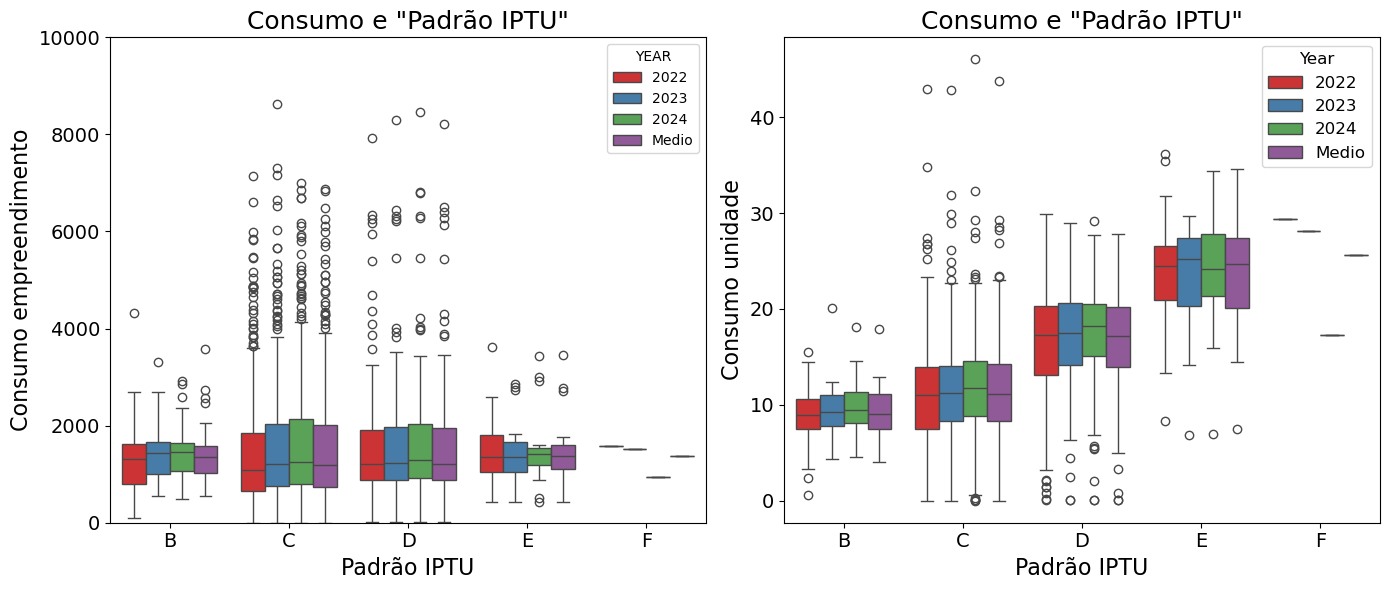

In [15]:
plot_map['title_text'] = 'Consumo e "{var_x}"'
dual_boxplot(data=pde_IGS, var_x='Padrao', var_y1='Consumo_anual', var_y2='Consumo_anual_Unidade',
                var_hue='YEAR', features_map=features_map, plot_map=plot_map, clip_yaxis = (0, 10000))

# Tendência lançamentos e tamanho das unidades

- **Idade** -> novas tecnologias de economia;
- **Tamanho** das unidades impacta no consumo
Predios antigo de alto padrao gastam mais - diferença menor hoje

In [31]:


def features_hued_analysis(data, var_x, var_y, var_hue, features_map, plot_map):
    """
    Plots a grid of three plots:
    - First row: A single box plot with hue.
    - Second row: Two side-by-side plots, each combining a violin plot and a box plot.

    Parameters:
    data : DataFrame
        The data frame containing the data for plotting.
    var_x : str
        The column name to use for the x-axis.
    var_y : str
        The column name to use for the y-axis in the second row.
    var_hue : str
        The column name to use for hue (coloring) in both plots.
    features_map : dict
        Dictionary containing customization options for each variable.
    plot_map : dict
        Dictionary containing plot-wide customization options.
    """
    # Create a figure with a 2-row, 2-column grid (first row spans both columns)
    fig = plt.figure(figsize = (14, 8))
    gs = fig.add_gridspec(2, 2, height_ratios = [1, 1])

    # First row (wide plot across both columns): Box plot with hue
    ax1 = fig.add_subplot(gs[0, :])
    palette_hue = features_map.get(var_hue, {}).get('palette', 'plasma')
    hue_order_hue = features_map.get(var_hue, {}).get('order', None)

    sns.boxplot(data = data, x = var_x, y = var_y, hue = var_hue, ax = ax1,
                palette = palette_hue, hue_order = hue_order_hue)
    ax1.set_title(plot_map['title_text'].format(var_x = features_map.get(var_x, {}).get('label', var_x),
                                                var_hue = features_map.get(var_hue, {}).get('label', var_hue)),
                  fontsize = plot_map.get('title_fontsize', 18))
    ax1.set_xlabel(features_map.get(var_x, {}).get('label', var_x), fontsize = plot_map.get('label_fontsize', 16))
    ax1.set_ylabel(features_map.get(var_y, {}).get('label', var_y), fontsize = plot_map.get('label_fontsize', 16))

    # Second row, first plot (violin + box plot for var_y)
    ax2 = fig.add_subplot(gs[1, 1])
    palette_y = features_map.get(var_x, {}).get('palette', 'viridis')
    hue_order_y = features_map.get(var_x, {}).get('order', None)

    sns.violinplot(data = data, x = var_x, y = var_y, ax = ax2, palette = palette_y, hue_order = hue_order_y,
                   split = True)
    sns.boxplot(data = data, x = var_x, y = var_y, ax = ax2,
                palette = palette_y, hue_order = hue_order_y, boxprops = {'facecolor': 'none'}, width = 0.3)

    ax2.set_title(plot_map['title_text'].format(var_x = features_map.get(var_y, {}).get('label', var_y),
                                                var_hue = features_map.get(var_x, {}).get('label', var_x)),
                  fontsize = plot_map.get('title_fontsize', 18))
    ax2.set_xlabel(features_map.get(var_x, {}).get('label', var_x), fontsize = plot_map.get('label_fontsize', 16))
    ax2.set_ylabel(features_map.get(var_y, {}).get('label', var_y), fontsize = plot_map.get('label_fontsize', 16))

    # Second row, second plot (violin + box plot for var_hue)
    ax3 = fig.add_subplot(gs[1, 0])
    sns.violinplot(data = data, x = var_hue, y = var_y, ax = ax3, palette = palette_hue, hue_order = hue_order_hue,
                   split = True)
    sns.boxplot(data = data, x = var_hue, y = var_y, ax = ax3,
                palette = palette_hue, hue_order = hue_order_hue, boxprops = {'facecolor': 'none'}, width = 0.3)

    ax3.set_title(plot_map['title_text'].format(var_x = features_map.get(var_y, {}).get('label', var_y),
                                                var_hue = features_map.get(var_hue, {}).get('label', var_hue)),
                  fontsize = plot_map.get('title_fontsize', 18))
    ax3.set_xlabel(features_map.get(var_hue, {}).get('label', var_hue), fontsize = plot_map.get('label_fontsize', 16))
    ax3.set_ylabel(features_map.get(var_y, {}).get('label', var_y), fontsize = plot_map.get('label_fontsize', 16))

    # Set tick label font sizes for all axes
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis = 'x', labelsize = plot_map.get('tick_fontsize', 14))
        ax.tick_params(axis = 'y', labelsize = plot_map.get('tick_fontsize', 14))

    # Set legends with custom font sizes
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, title = features_map.get(var_hue, {}).get('label', var_hue),
               title_fontsize = plot_map.get('legend_fontsize', 14),
               fontsize = plot_map.get('legend_fontsize', 12))

    plt.tight_layout()
    plt.savefig('violin.pdf', dpi = 500, transparent = True)
    plt.show()

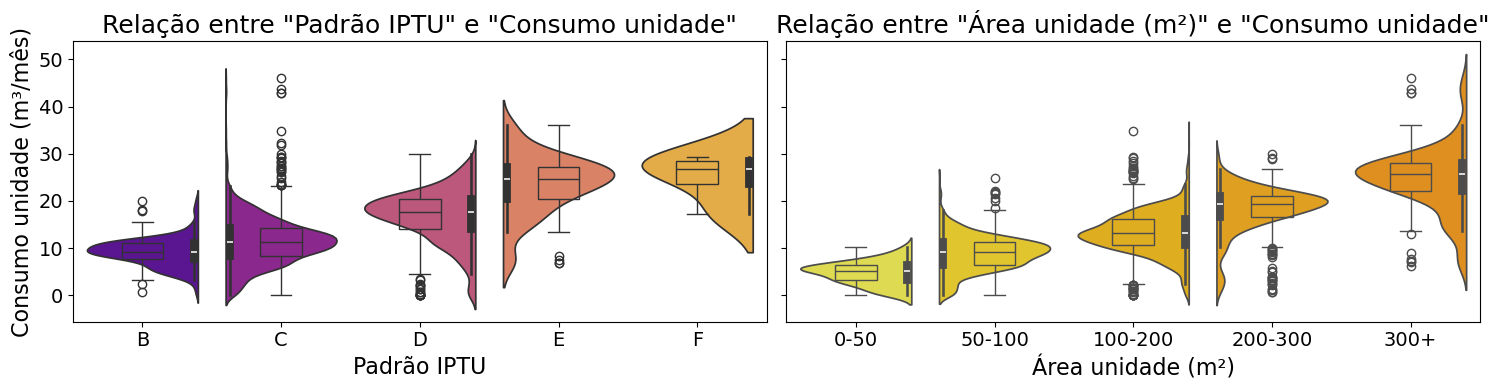

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_side_by_side(data, var_x, var_y, var_hue, features_map, plot_map):
    """
    Plots the last two plots from the original grid side by side.
    
    Parameters:
    data : DataFrame
        The data frame containing the data for plotting.
    var_x : str
        The column name to use for the x-axis in the first plot.
    var_y : str
        The column name to use for the y-axis.
    var_hue : str
        The column name to use for hue (coloring) in the second plot.
    features_map : dict
        Dictionary containing customization options for each variable.
    plot_map : dict
        Dictionary containing plot-wide customization options.
    """
    # Create a new figure with a 1-row, 2-column grid
    fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
    
    # Second row, first plot (violin + box plot for var_y)
    palette_y = features_map.get(var_x, {}).get('palette', 'viridis')
    hue_order_y = features_map.get(var_x, {}).get('order', None)

    sns.violinplot(data=data, x=var_x, y=var_y, ax=axes[1], palette=palette_y, hue_order=hue_order_y, split=True)
    sns.boxplot(data=data, x=var_x, y=var_y, ax=axes[1],
                palette=palette_y, hue_order=hue_order_y, boxprops={'facecolor': 'none'}, width=0.3)

    axes[1].set_title(plot_map['title_text'].format(var_x=features_map.get(var_y, {}).get('label', var_y),
                                                    var_hue=features_map.get(var_x, {}).get('label', var_x)),
                      fontsize=plot_map.get('title_fontsize', 18))
    axes[1].set_xlabel(features_map.get(var_x, {}).get('label', var_x), fontsize=plot_map.get('label_fontsize', 16))
    axes[1].set_ylabel(features_map.get(var_y, {}).get('label', var_y) + ' (m³/mês)', fontsize=plot_map.get('label_fontsize', 16))

    # Second row, second plot (violin + box plot for var_hue)
    palette_hue = features_map.get(var_hue, {}).get('palette', 'plasma')
    hue_order_hue = features_map.get(var_hue, {}).get('order', None)

    sns.violinplot(data=data, x=var_hue, y=var_y, ax=axes[0], palette=palette_hue, hue_order=hue_order_hue, split=True)
    sns.boxplot(data=data, x=var_hue, y=var_y, ax=axes[0],
                palette=palette_hue, hue_order=hue_order_hue, boxprops={'facecolor': 'none'}, width=0.3)

    axes[0].set_title(plot_map['title_text'].format(var_x=features_map.get(var_y, {}).get('label', var_y),
                                                    var_hue=features_map.get(var_hue, {}).get('label', var_hue)),
                      fontsize=plot_map.get('title_fontsize', 18))
    axes[0].set_xlabel(features_map.get(var_hue, {}).get('label', var_hue), fontsize=plot_map.get('label_fontsize', 16))
    axes[0].set_ylabel(features_map.get(var_y, {}).get('label', var_y) + ' (m³/mês)', fontsize=plot_map.get('label_fontsize', 16))

    # Set tick label font sizes
    for ax in axes:
        ax.tick_params(axis='x', labelsize=plot_map.get('tick_fontsize', 14))
        ax.tick_params(axis='y', labelsize=plot_map.get('tick_fontsize', 14))

    plt.tight_layout()
    plt.savefig('violins.pdf', dpi=500, transparent=True)
    plt.show()


plot_side_by_side(data=pde_IGS, var_x='m2_tipo_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

In [55]:
features_map['Consumo_anual_Unidade']['label'] = 'Consumo unidade'

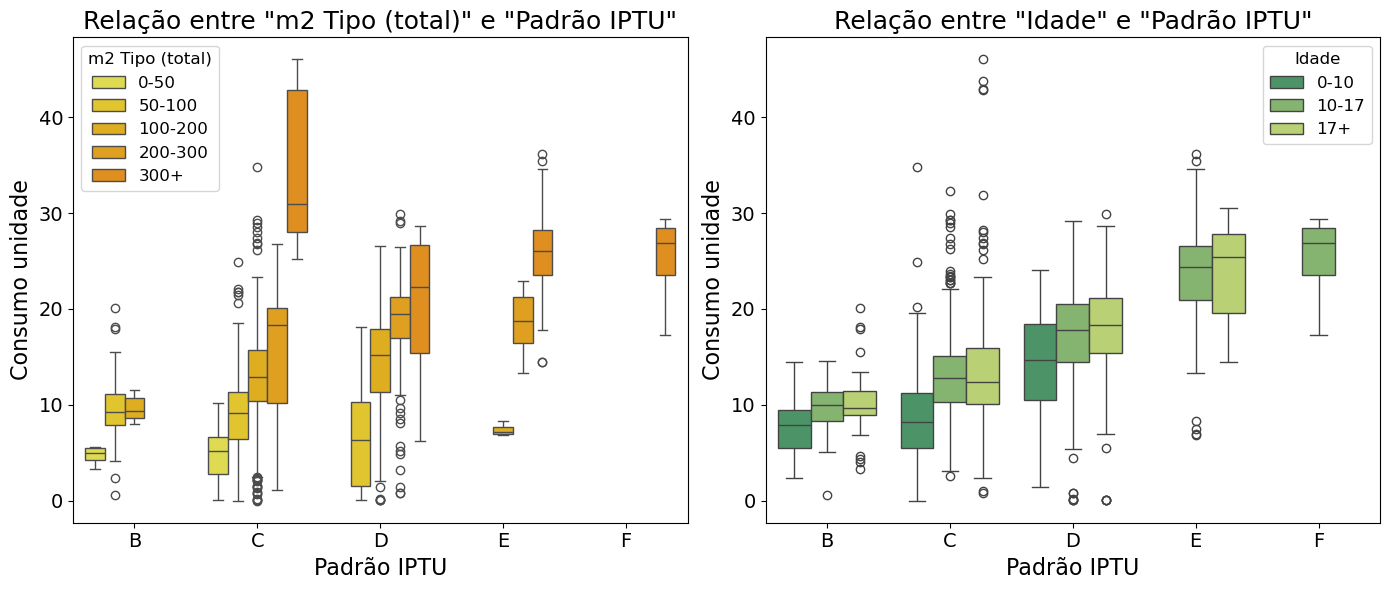

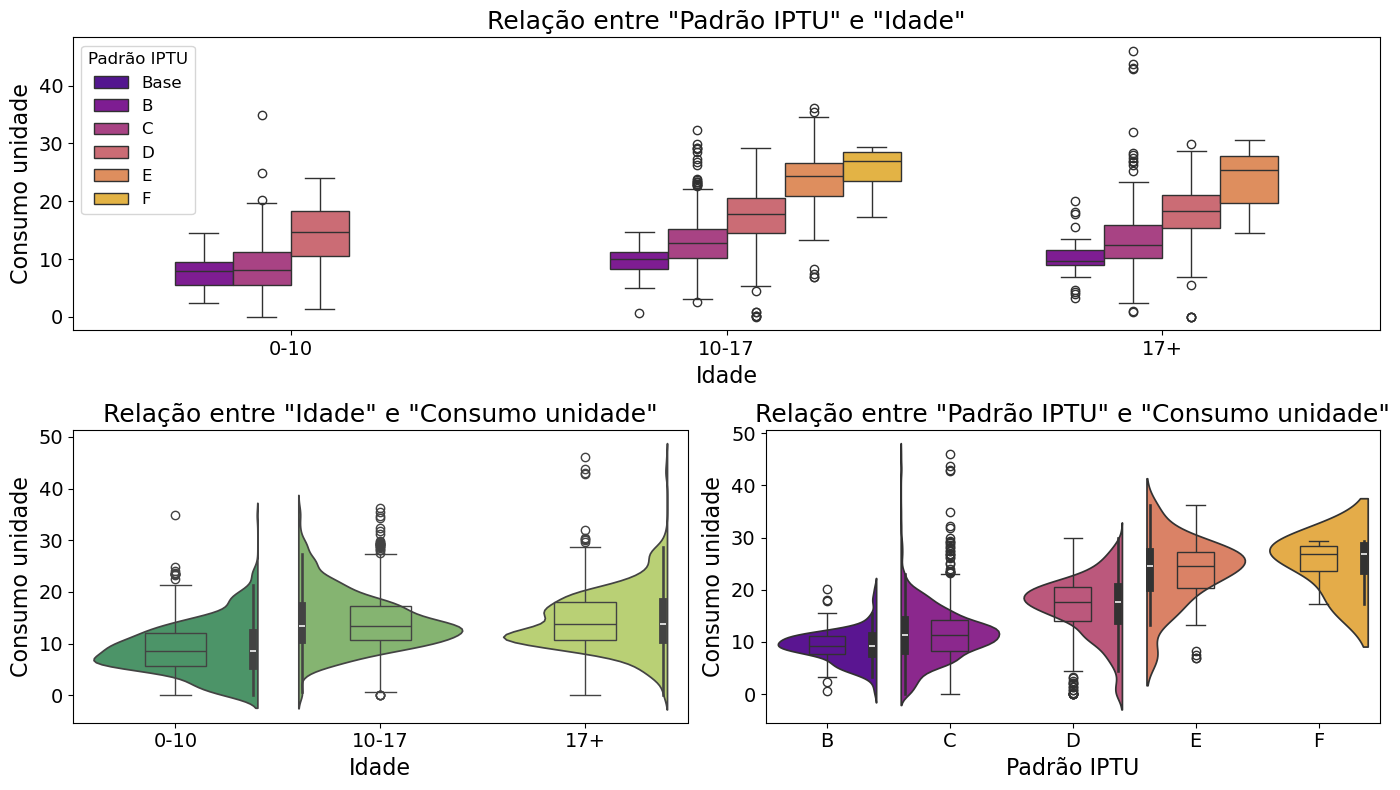

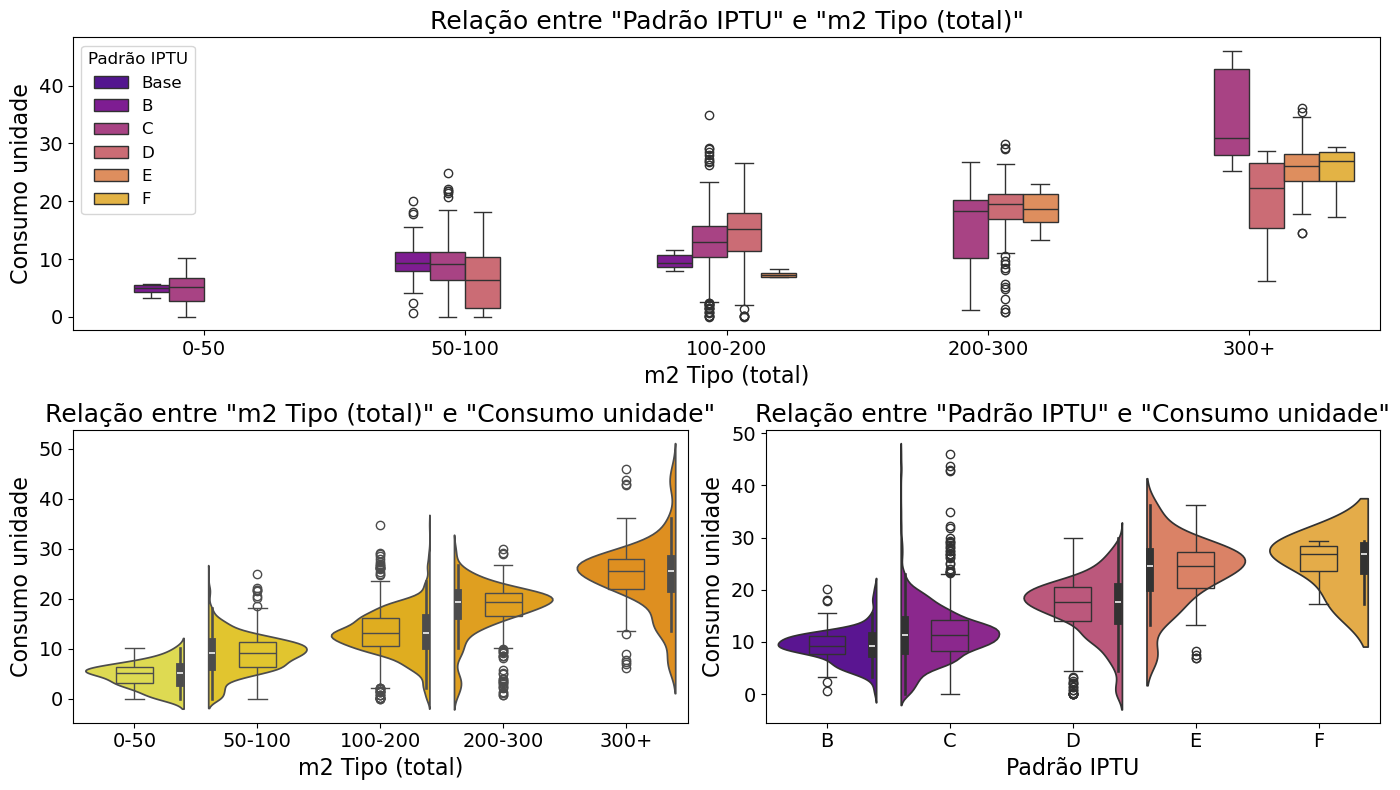

In [16]:
plot_map['title_text'] = 'Relação entre "{var_hue}" e "{var_x}"'
dual_boxplot_hued(data=pde_IGS, var_x='Padrao', var_y='Consumo_anual_Unidade',
                  var_hue1='m2_tipo_bins', var_hue2='idade_bins',
                  features_map=features_map, plot_map=plot_map)

features_hued_analysis(data=pde_IGS, var_x='idade_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

features_hued_analysis(data=pde_IGS, var_x='m2_tipo_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

# Quanto ao número de residentes

- Banheiros por unidade
- DOrmitorios por unidade

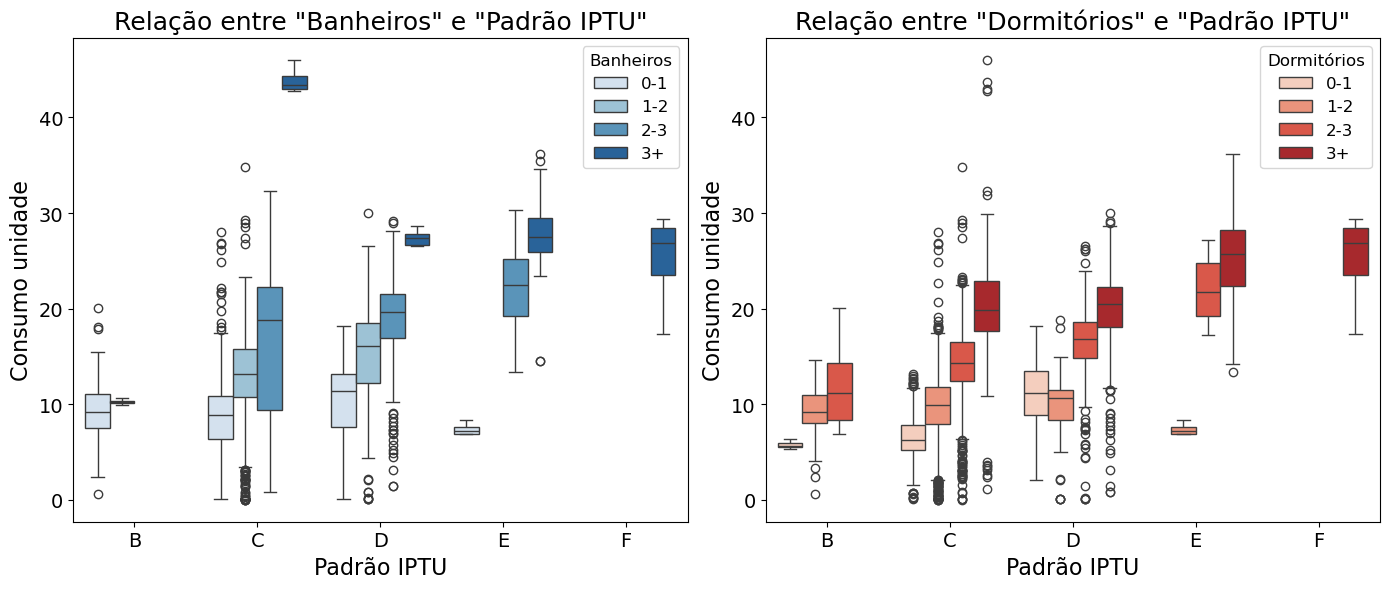

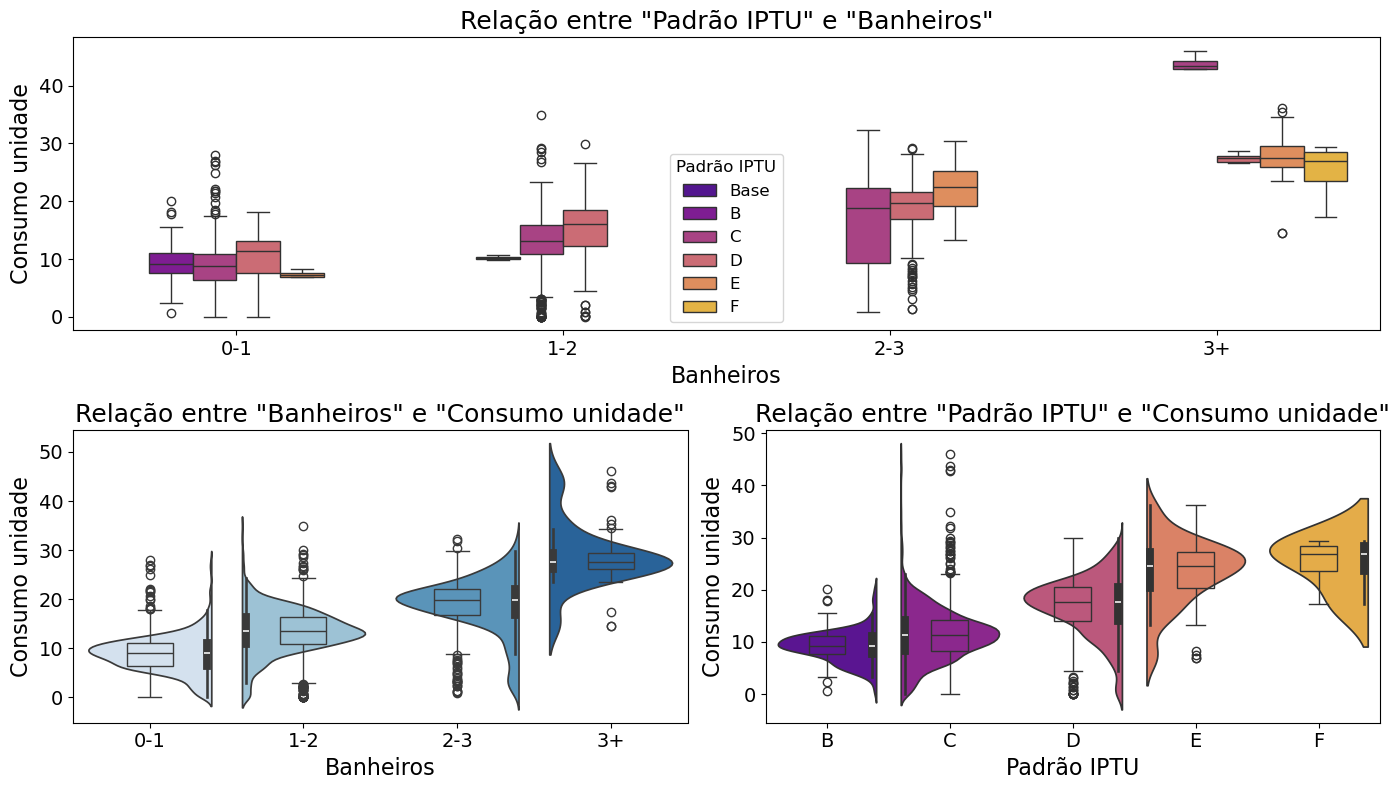

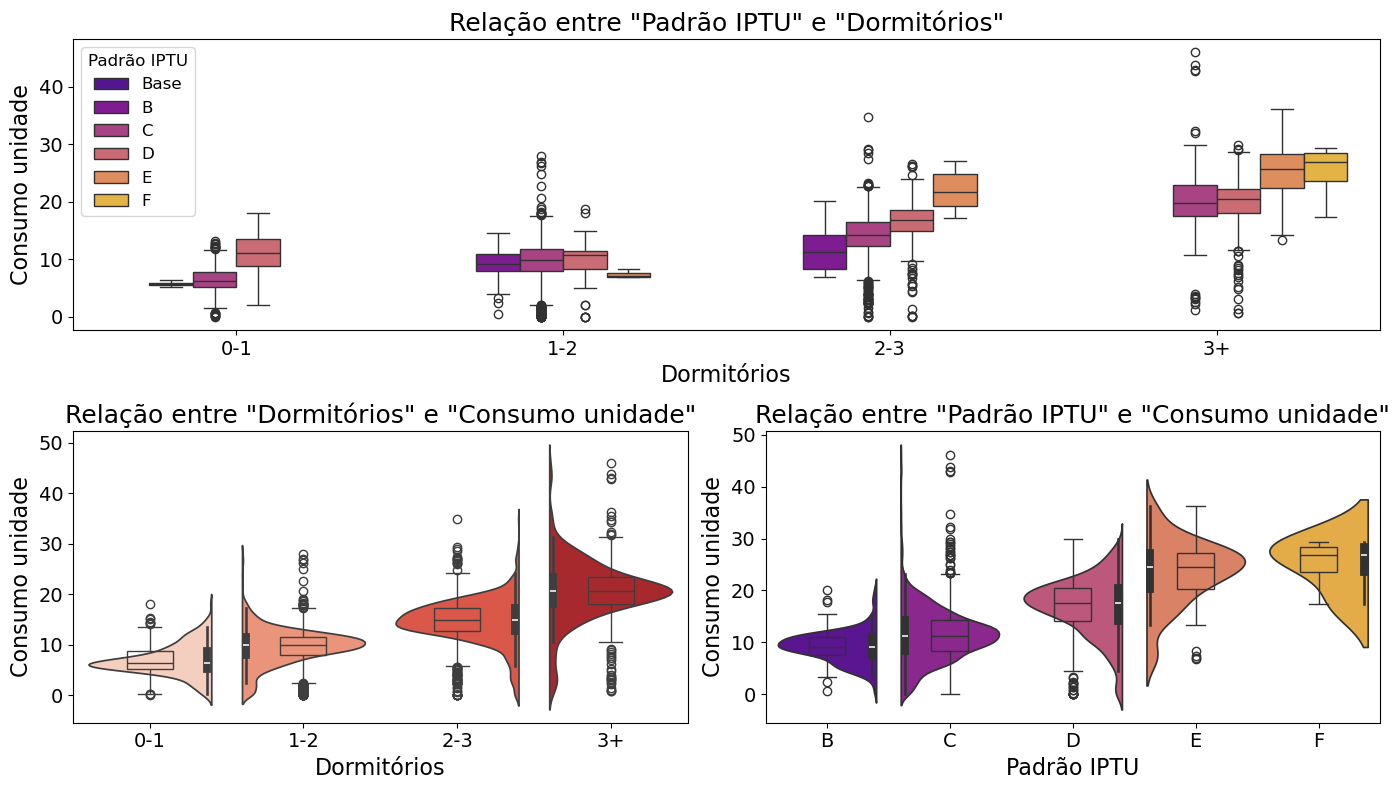

In [17]:
plot_map['title_text'] = 'Relação entre "{var_hue}" e "{var_x}"'
dual_boxplot_hued(data=pde_IGS, var_x='Padrao', var_y='Consumo_anual_Unidade',
                  var_hue1='banheiros_bins', var_hue2='dormitorios_bins',
                  features_map=features_map, plot_map=plot_map)

features_hued_analysis(data=pde_IGS, var_x='banheiros_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

features_hued_analysis(data=pde_IGS, var_x='dormitorios_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

# Exemplo de variavel sem impacto relevante: área do terreno

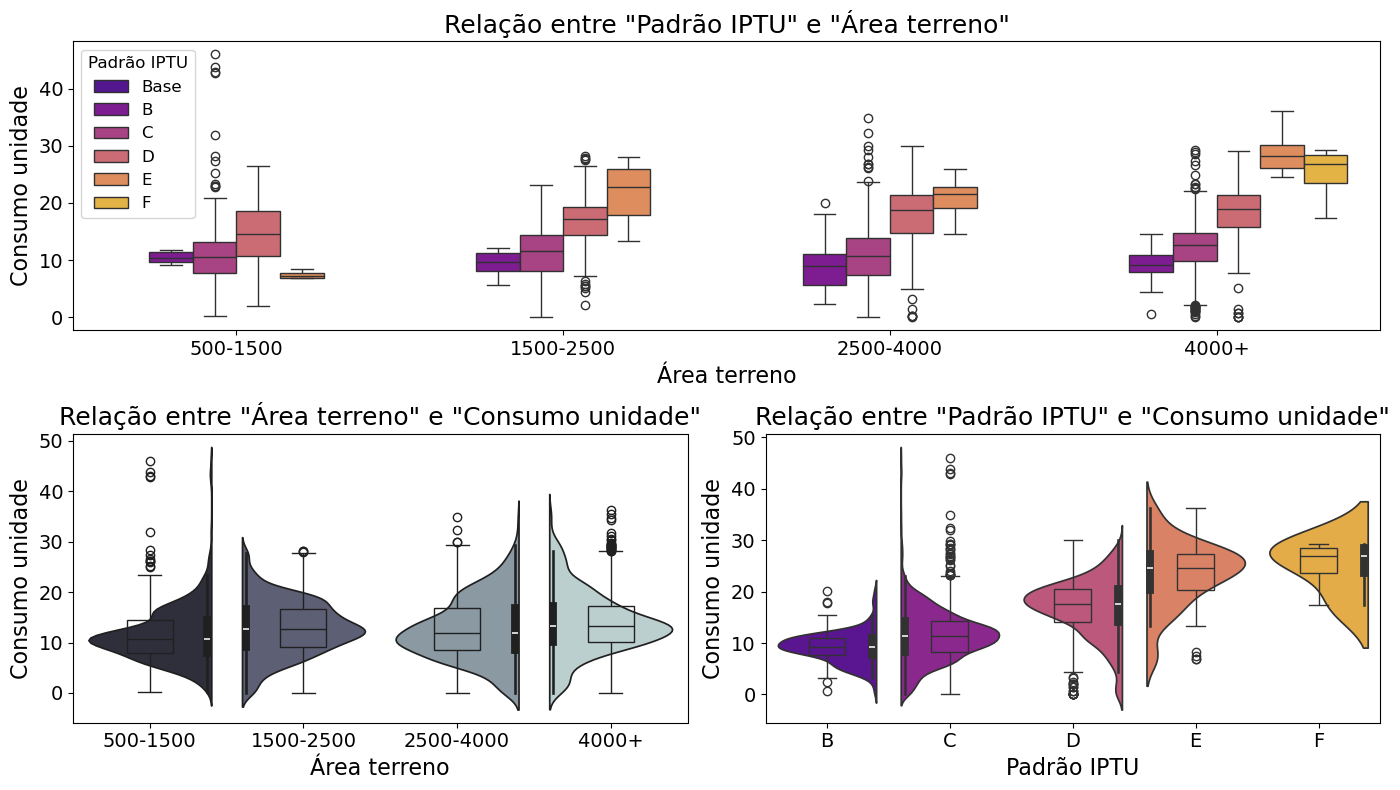

In [18]:
features_hued_analysis(data=pde_IGS, var_x='Area_terr_bins', var_y='Consumo_anual_Unidade',
                var_hue='Padrao', features_map=features_map, plot_map=plot_map)

In [19]:
pde_IGS

,Empreendimento_Nome,DESC_RUA,NUMERO_RUA,Padrao,M2_total_unidade_tipo,dormitorios_bins,banheiros_bins,Area_terr_bins,m2_tipo_bins,idade_bins,Total_Unidades,CONTAGEM_UNIDADES,ratio_units,PDE,YEAR,Consumo_anual,Consumo_medio_anual,Consumo_anual_Unidade,Consumo_medio_anual_Unidade
240,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2022,1425.727273,1273.454545,5.280471,4.716498
241,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2023,1519.833333,1544.333333,5.629012,5.719753
242,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,2024,1486.444444,1485.444444,5.505350,5.501646
243,VITA BOM RETIRO RESIDENCIAL,ANHAIA,871.0,B,41.306667,0-1,0-1,2500-4000,0-50,0-10,270.0,292.000000,0.924658,0906908850,Medio,1478.093750,1434.656250,5.474421,5.313542
3278,RESIDENCIAL VINTE E CINCO DE JANEIRO,VINTE E CINCO DE JANEIRO,151.0,B,48.300000,1-2,0-1,2500-4000,0-50,17+,300.0,170.906667,1.755344,0709972091,2022,989.583333,985.500000,3.298611,3.285000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,DOMANI PARQUE,PERIQUITO,225.0,E,412.360000,3+,3+,2500-4000,300+,17+,52.0,54.000000,0.962963,0932616240,Medio,753.800000,806.200000,14.496154,15.503846
798,IDENTITÀ TENNIS & CLUB TATUAPÉ,COELHO LISBOA,579.0,F,424.910000,3+,3+,4000+,300+,10-17,54.0,56.000000,0.964286,0159313074,2022,1584.666667,1573.833333,29.345679,29.145062
799,IDENTITÀ TENNIS & CLUB TATUAPÉ,COELHO LISBOA,579.0,F,424.910000,3+,3+,4000+,300+,10-17,54.0,56.000000,0.964286,0159313074,2023,1518.500000,1591.750000,28.120370,29.476852
800,IDENTITÀ TENNIS & CLUB TATUAPÉ,COELHO LISBOA,579.0,F,424.910000,3+,3+,4000+,300+,10-17,54.0,56.000000,0.964286,0159313074,2024,935.222222,1045.444444,17.318930,19.360082


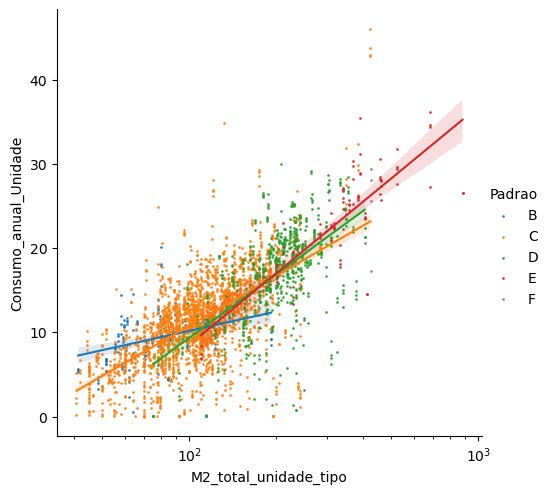

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to exclude 'Base' from 'Padrao'
filtered_data = pde_IGS[pde_IGS['Padrao'] != 'Base']

# Use sns.lmplot to plot each hue category with its own regression line
sns.lmplot(
    data=filtered_data,
    x='M2_total_unidade_tipo',
    y='Consumo_anual_Unidade',
    hue='Padrao',
    logx=True,
    scatter_kws={'s': 1,},  # Adjusts the size of scatter points
    line_kws={'linewidth': 1.5}  # Adjusts the thickness of regression lines
)

# Set x-axis to log scale (lmplot with logx=True will do this automatically)
plt.xscale('log')

# Show the plot
plt.show()
